#### Script to check rf and compute the visuomemory index block 1
- First, check if neuron responding to the task by comparing activity during trial vs baseline
- Second, check whether the rf is in in or out
- Third, compute the visuomemory index

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import align_trials,select_trials
from ephysvibe.task import task_constants
from ephysvibe.structures.neuron_data import NeuronData
from scipy import stats
import platform

### Def functions

In [44]:
def find_latency(p_value:np.ndarray,win:int, step:int=1)-> np.ndarray:
    sig=np.full(p_value.shape[0],False)
    sig[p_value<0.05]=True
    for i_step in np.arange(0,sig.shape[0],step):
        sig[i_step] = np.where(np.all(p_value[i_step:i_step+win]<0.05),True,False)
    latency = np.where(sig)[0]

    if len(latency)!=0:
        endl = np.where(np.cumsum(sig[latency[0]:])==0)[0]
        endl=endl[0] if len(endl)!=0 else -1
        return latency[0],endl
    else:
        return np.nan,np.nan

In [45]:
def get_vd_index(bl, group1, group2, step=1, avg_win=100, pwin=75):
    p_son, p_d = [], []
    bl = np.mean(bl, axis=1)
    for i in range(0, group1.shape[1] - avg_win, step):
        g1 = np.mean(group1[:, i : i + avg_win], axis=1)
        p_son.append(stats.ranksums(bl, g1)[1])
    for i in range(0, group2.shape[1] - avg_win, step):
        g2 = np.mean(group2[:, i : i + avg_win], axis=1)
        p_d.append(stats.ranksums(bl, g2)[1])
    p_son = np.array(p_son)
    p_d = np.array(p_d)
    lat_son,end_son = find_latency(p_value=p_son, win=pwin, step=1)
    lat_d,end_d = find_latency(p_value=p_d, win=pwin, step=1)
    if np.logical_and(np.isnan(lat_son), ~np.isnan(lat_d)):
        g1 = group1
        g2 = group2[:, lat_d : end_d]
    elif np.logical_and(~np.isnan(lat_son), np.isnan(lat_d)):
        g1 = group1[:, lat_son : end_son]
        g2 = group2
    elif np.logical_and(np.isnan(lat_son), np.isnan(lat_d)):
        return np.nan
    else:
        g1 = group1[:, lat_son : end_son]
        g2 = group2[:, lat_d : end_d]
    bl_mean = np.mean(bl)
    g1_mean = np.mean(g1)
    g2_mean = np.mean(g2)
    g2_mean_bl = np.abs(g2_mean - bl_mean)
    g1_mean_bl = np.abs(g1_mean - bl_mean)
    return (g2_mean_bl - g1_mean_bl) / (g1_mean_bl + g2_mean_bl)

In [46]:
def get_align_tr(neu_data,select_block,select_pos,time_before,event ="sample_on"):
    sp,mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block= select_block,
        select_pos= select_pos,
        event =event,
        time_before = time_before,
        error_type= 0,
    )
    return sp,mask

In [47]:
def plot_raster_conv(sp_sample, start, conv, time, ax1, ax2, colors):
    n_trials = 0
    for key, sp in sp_sample.items():
        # ----- plot conv----------
        ax1.plot(time, conv[key], color=colors[key])
        # ----- plot spikes----------
        rows, cols = np.where(sp >= 1)
        ax2.scatter(
            cols + start,
            rows + n_trials,
            marker="|",
            alpha=1,
            edgecolors="none",
            color=colors[key],
            label="sample %s" % key,
        )
        n_trials = n_trials + sp.shape[0]

    return ax1, ax2, n_trials

### Start analysis

In [48]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'
basepath = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'

#### Select parameters

In [49]:
# parameters
time_before=200
start=-200
end=1000
idx_start = time_before + start 
idx_end = time_before+end
# ---conv
# fs = 1000
# w_size=0.1
# w_std=0.015
# Timings 
## fixation
dur_fix = 200
## visual stim
st_v =   80
end_v = 300
## delay
st_d = 600 
end_d = 800
# trials and threshold
min_trials = 3
n_spikes = 1
p_threshold = 0.05
vd_threshold = 0.4

In [50]:
neu_path = basepath+"session_struct/v4/neurons/2022-11-22_10-59-03_Riesling_v4_e1_r1_good9_neu.h5"
neu_data = NeuronData.from_python_hdf5(neu_path)

In [51]:
time_before = 200
# get spike matrices in and out conditions
sp_in, mask_in = get_align_tr(
    neu_data, select_block=1, select_pos=1, time_before=time_before
)
sp_in=sp_in[neu_data.sample_id[mask_in]!=0]
sp_out, mask_out = get_align_tr(
    neu_data, select_block=1, select_pos=-1, time_before=time_before
)
sp_out=sp_out[neu_data.sample_id[mask_out]!=0]
sp_din, mask_din = get_align_tr(
    neu_data, select_block=1, select_pos=1, time_before=0, event="sample_off"
)
sp_din=sp_din[neu_data.sample_id[mask_din]!=0]
sp_dout, mask_dout = get_align_tr(
    neu_data, select_block=1, select_pos=-1, time_before=0, event="sample_off"
)
sp_dout=sp_dout[neu_data.sample_id[mask_dout]!=0]


#### Compute VD index

In [52]:
# Select durarion to analyze
sp_in = sp_in[:, : time_before + 460 + 700]
sp_out = sp_out[:, : time_before + 460 + 700]
# Select durarion to analyze
sp_din = sp_din[:, :350]
sp_dout = sp_dout[:, :350]
# get avg fr over trials and time
vd_in = np.nan
vd_out = np.nan
i_st = 10
if np.logical_and(sp_din.shape[0] > 2, sp_din.ndim > 1):
    vd_in = get_vd_index(
        bl=sp_in[:, :time_before],
        group1=sp_in[:, time_before + i_st : time_before + i_st + 460],
        group2=sp_din[:, i_st:400],
        step=1,
        avg_win=100,
        pwin=75,
    )
if np.logical_and(sp_dout.shape[0] > 2, sp_dout.ndim > 1):
    vd_out = get_vd_index(
        bl=sp_out[:, :time_before],
        group1=sp_out[:, time_before + i_st : time_before + i_st + 460],
        group2=sp_dout[:, i_st:400],
        step=1,
        avg_win=100,
        pwin=75,
    )

In [53]:
vd_in

-0.6238019169329091

In [54]:
vd_out

-0.2892774965485504

C:\Users\camil\AppData\Local\Temp\ipykernel_21148\2292913546.py:8: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(


Text(0.05, 0.99, '2022-11-22_10-59-03: v4 good 9 ')

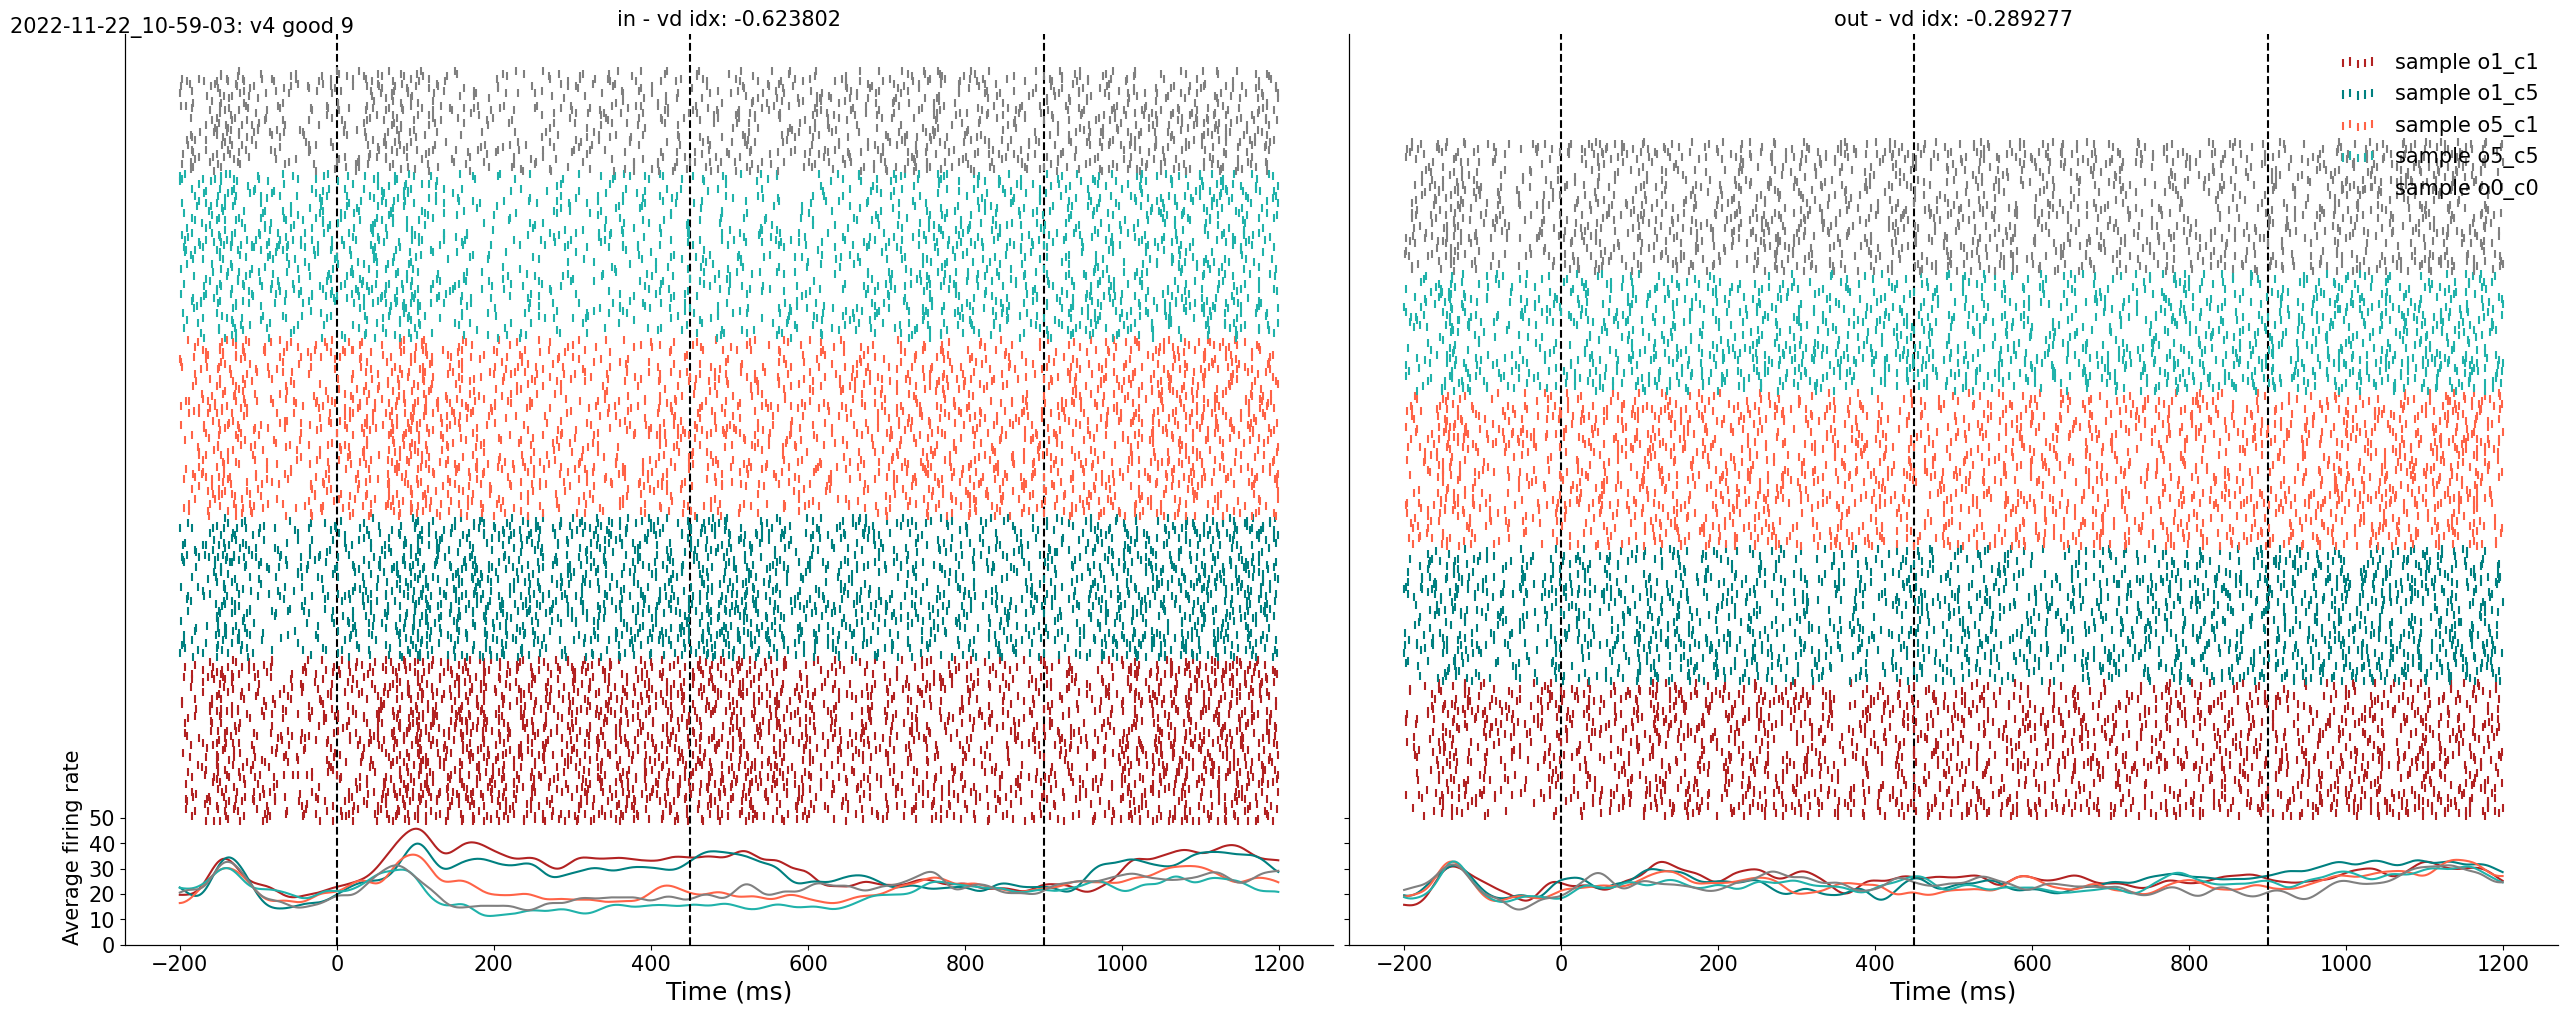

In [55]:
# parameters
time_before = 500
select_block = 1
start = -200
end = 1200
idx_start = time_before + start
idx_end = time_before + end
# ---------------
conv_all = {"in": {}, "out": {}}
all_sp_by_sample = {"in": {}, "out": {}}
pos_label = ["in", "out"]
pos_code = [1, -1]
count_trials = 0
all_max_conv = 0
all_max_trial = 0
for code, pos in zip(pos_code, pos_label):
    # select correct trials, block one, inside/outside RF, and align with sample onset
    sp_sample_on, mask = align_trials.align_on(
        sp_samples=neu_data.sp_samples,
        code_samples=neu_data.code_samples,
        code_numbers=neu_data.code_numbers,
        trial_error=neu_data.trial_error,
        block=neu_data.block,
        pos_code=neu_data.pos_code,
        select_block=select_block,
        select_pos=code,
        event="sample_on",
        time_before=time_before,
        error_type=0,
    )

    sample_id = neu_data.sample_id[mask]
    sp_by_sample = select_trials.get_sp_by_sample(sp_sample_on, sample_id)
    for key, value in sp_by_sample.items():
        arr = value.mean(axis=0)
        conv = firing_rate.convolve_signal(
            arr=arr, fs=1000, w_size=0.1, w_std=0.015, axis=0
        )[idx_start:idx_end]
        conv_all[pos][key] = conv
        sp_by_sample[key] = value[:, idx_start:idx_end]
        count_trials = value.shape[0]
        max_conv = np.max(conv)
        all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
        all_max_trial = (
            count_trials if count_trials > all_max_trial else all_max_trial
        )
    all_sp_by_sample[pos] = sp_by_sample

fig, (ax_in, ax_out) = plt.subplots(nrows=1, ncols=2, figsize=(25, 10), sharey=True)

time = np.arange(0, end - start) + start
ax_in_2 = ax_in.twinx()
pos = "in"
ax_in, ax_in_2, n_trials_in = plot_raster_conv(
    all_sp_by_sample[pos],
    start,
    conv_all[pos],
    time,
    ax_in,
    ax_in_2,
    colors=task_constants.PALETTE_B1,
)
ax_out_2 = ax_out.twinx()
pos = "out"
ax_out, ax_out_2, n_trials_out = plot_raster_conv(
    all_sp_by_sample[pos],
    start,
    conv_all[pos],
    time,
    ax_out,
    ax_out_2,
    colors=task_constants.PALETTE_B1,
)

all_max_trial = max([n_trials_in, n_trials_out])
# -----parameters in plot
ax_in_2.axes.set_yticks(np.arange(-all_max_conv - 5, all_max_trial))
ax_in.axes.set_ylim(0, all_max_conv + all_max_trial + 5)
ax_in.axes.set_yticks(np.arange(0, all_max_conv + 5, 10))
plt.setp(ax_in_2.axes.get_yticklabels(), visible=False)
plt.setp(ax_in_2.axes.get_yaxis(), visible=False)
ax_in.set_title("in - vd idx: %f"%vd_in, fontsize=15)
ax_in.vlines(
    [0, 450, 900],
    0,
    all_max_conv + all_max_trial + 5,
    color="k",
    linestyles="dashed",
)
ax_in.spines["right"].set_visible(False)
ax_in.spines["top"].set_visible(False)
ax_in_2.spines["right"].set_visible(False)
ax_in_2.spines["top"].set_visible(False)
ax_in.set_xlabel(xlabel="Time (ms)", fontsize=18)
ax_in.set_ylabel(ylabel="Average firing rate", fontsize=15, loc="bottom")
for xtick in ax_in.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15)
for ytick in ax_in.yaxis.get_major_ticks():
    ytick.label1.set_fontsize(15)
for xtick in ax_in_2.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15)
# -----parameters out plot
ax_out_2.axes.set_yticks(np.arange(-all_max_conv - 5, all_max_trial))
ax_out.axes.set_ylim(0, all_max_conv + all_max_trial + 5)
ax_out.axes.set_yticks(np.arange(0, all_max_conv + 5, 10))
plt.setp(ax_out_2.axes.get_yticklabels(), visible=False)
plt.setp(ax_out_2.axes.get_yaxis(), visible=False)
ax_out.set_title("out - vd idx: %f"%vd_out, fontsize=15)
ax_out.vlines(
    [0, 450, 900],
    0,
    all_max_conv + all_max_trial + 5,
    color="k",
    linestyles="dashed",
)
ax_out.spines["right"].set_visible(False)
ax_out.spines["top"].set_visible(False)
ax_out_2.spines["right"].set_visible(False)
ax_out_2.spines["top"].set_visible(False)
ax_out.set_xlabel(xlabel="Time (ms)", fontsize=18)
for xtick in ax_out.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15)
for ytick in ax_out.yaxis.get_major_ticks():
    ytick.label1.set_fontsize(15)
for xtick in ax_out_2.xaxis.get_major_ticks():
    xtick.label1.set_fontsize(15)
ax_out_2.legend(
    fontsize=15, scatterpoints=5, columnspacing=0.5, framealpha=0, loc="upper right"
)
## --- figure
fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
fig.suptitle(
    "%s: %s %s %d "
    % (
        neu_data.date_time,
        neu_data.area,
        neu_data.cluster_group,
        neu_data.cluster_number,
    ),
    x=0.05,
    y=0.99,
    fontsize=15,
)